VECTOR AUTOREGRESSION MODEL OF GOOGLE STOCK DATA 

Importing All the necessary libraries

In [134]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic

In [135]:
stock_data1 = pd.read_csv("Google Dataset 1.csv", parse_dates=['Date'], index_col='Date')

In [136]:
stock_data1.head(10)

,Open,High,Low,Close,Change %,Avg. Volume,Unnamed: 7
Date,,,,,,,
2022-01-12,101.38,102.59,100.67,101.28,-0.17%,"2,17,71,536",NaN
2022-01-11,95.59,101.45,83.45,101.45,7.17%,"2,82,94,944",NaN
2022-03-10,97.22,105.10,91.90,94.66,-1.55%,"2,78,43,110",NaN
2022-01-09,109.20,112.64,96.03,96.15,-11.91%,"2,53,81,194",NaN
2022-01-08,115.53,123.26,108.80,109.15,-6.42%,"1,87,37,451",NaN
2022-01-07,108.34,120.44,104.76,116.64,6.64%,"3,19,45,632",NaN
2022-01-06,114.93,119.40,105.63,109.37,-4.09%,"2,98,65,028",NaN
2022-01-05,113.91,123.14,102.21,114.04,-0.81%,"3,41,65,949",NaN
2022-01-04,140.01,144.04,113.12,114.97,-17.67%,"2,82,47,285",NaN


In [137]:
stock_data1.tail(10)

,Open,High,Low,Close,Change %,Avg. Volume,Unnamed: 7
Date,,,,,,,
2014-02-12,26.94,27.07,24.45,26.32,-2.85%,"4,16,34,440",NaN
2014-01-11,27.77,27.89,26.50,27.09,-3.09%,"2,99,43,707",NaN
2014-01-10,28.80,29.05,25.40,27.95,-3.17%,"4,52,90,843",NaN
2014-02-09,28.59,29.82,28.41,28.87,1.01%,"3,18,73,775",NaN
2014-01-08,28.52,29.37,28.00,28.58,0.00%,"2,63,13,579",NaN
2014-01-07,28.92,29.98,28.25,28.58,-0.64%,"3,14,11,358",NaN
2014-02-06,28.03,29.12,26.94,28.76,2.75%,"3,61,21,936",NaN
2014-01-05,26.35,28.39,25.16,27.99,6.31%,"3,48,08,252",NaN
2014-01-04,27.93,30.24,25.14,26.33,-5.44%,"6,40,37,909",NaN


Data Cleaning of the Data - chaning the Dtypes of the COlumns from object to float so that we can do advance mathematical operations on the data

In [138]:
stock_data1['Change %'] = stock_data1['Change %'].str.rstrip("%").astype(float)/100


In [140]:
stock_data1['Avg. Volume'] = stock_data1['Avg. Volume'].str.replace(',', '')

In [141]:
stock_data1['Avg. Volume'] = stock_data1['Avg. Volume'].astype(float)


In [142]:
stock_data1.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 106 entries, 2022-01-12 to 2014-02-03
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Open         106 non-null    float64
 1   High         106 non-null    float64
 2   Low          106 non-null    float64
 3   Close        106 non-null    float64
 4   Change %     106 non-null    float64
 5   Avg. Volume  106 non-null    float64
 6   Unnamed: 7   0 non-null      float64
dtypes: float64(7)
memory usage: 6.6 KB


In [143]:
stock_data1.describe()

,Open,High,Low,Close,Change %,Avg. Volume,Unnamed: 7
count,106.000000,106.000000,106.000000,106.000000,106.000000,1.060000e+02,0.0
mean,63.558019,67.674151,60.285283,64.184623,0.014329,3.299223e+07,NaN
std,34.705462,36.999070,32.339007,34.598918,0.065133,9.553159e+06,NaN
min,26.240000,27.070000,24.380000,26.030000,-0.176700,4.321920e+05,NaN
25%,37.202500,38.947500,34.660000,37.412500,-0.020900,2.745647e+07,NaN
50%,54.925000,58.025000,50.665000,54.950000,0.011500,3.088268e+07,NaN
75%,79.640000,86.082500,72.647500,81.545000,0.056900,3.654029e+07,NaN
max,148.170000,152.100000,142.070000,148.270000,0.201900,6.490765e+07,NaN


In [144]:
stock_data1 = stock_data1.drop(['Unnamed: 7'], axis=1)

In [145]:
stock_data1.shape

(106, 6)

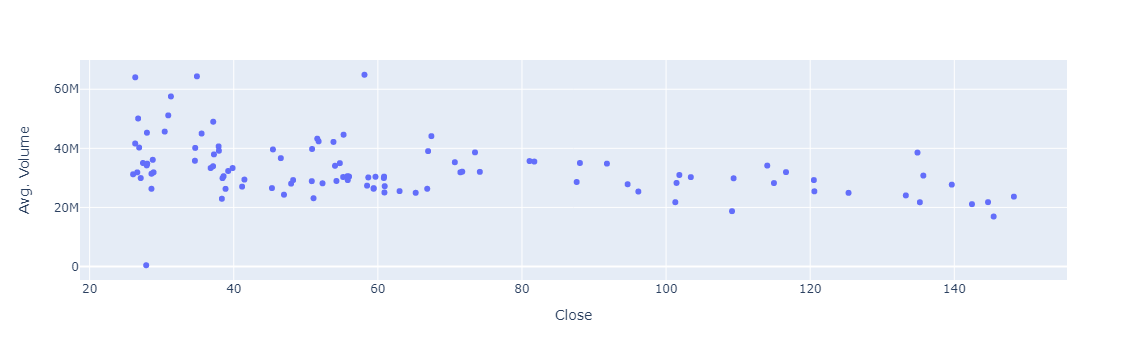

In [164]:
import plotly.express as px
fig = px.scatter(stock_data1, x = "Close", y = "Avg. Volume")
fig.show()
    

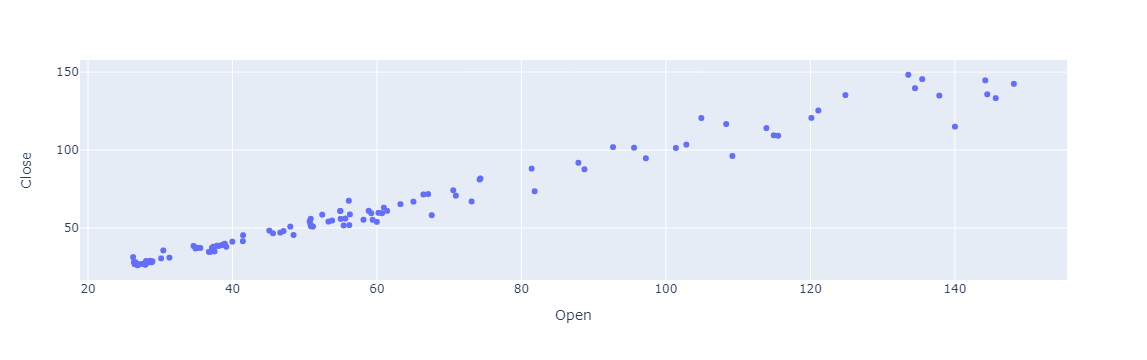

In [147]:
fig = px.scatter(stock_data1, x = "Open", y = "Close")
fig.show()

Scatter Plot Depicting the Linearity, spread and association of the Variables

Testing Causation using Granger’s Causality Test

If a given p-value is < significance level (0.05), then, the corresponding X series (column) causes the Y (row).
So, you can reject the null hypothesis and conclude Open_x causes Close_y

In [148]:
from statsmodels.tsa.stattools import grangercausalitytests
maxlag = 5
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test = 'ssr_chi2test', verbose = False):
    variables = ['Open', 'High', 'Low', 'Close', 'Change %', 'Avg.Volume']
    stock_data1 = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in stock_data1.columns:
        for r in stock_data.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag = maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1], 4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_values = np.min(p_values)
            stock_data1.loc[r, c] = min_p_values
    stock_data1.columns = [var + '_x' for var in variables]
    stock_data1.index = [var + '_y' for var in variables]
    return stock_data1
grangers_causation_matrix(stock_data1, variables = stock_data1.columns)

,Open_x,High_x,Low_x,Close_x,Change %_x,Avg.Volume_x
Open_y,0.0,0.0,0.0,0.0,0.0,0.0
High_y,0.0,0.0,0.0,0.0,0.0,0.0
Low_y,0.0,0.0,0.0,0.0,0.0,0.0
Close_y,0.0,0.0,0.0,0.0,0.0,0.0
Change %_y,0.0,0.0,0.0,0.0,0.0,0.0
Avg.Volume_y,0.0,0.0,0.0,0.0,0.0,0.0


Splitting the Dataset Into Train Set and Test Set

In [149]:
nobs = 10
stock_data1_train, stock_data1_test = stock_data1[0:-nobs], stock_data1[-nobs:]
print(stock_data1_train.shape)
print(stock_data1_test.shape)

(96, 6)
(10, 6)


Checking The Stationarity of the Dataset using the Augmented Dicky-Fuller Test
ADF test is fundamentally a statistical significance test. That means, there is a hypothesis testing involved with a null and alternate hypothesis and as a result a test statistic is computed and p-values get reported.


In [150]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)
    
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')
    
    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")    

In [151]:
for name, column in stock_data1_train.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "Open" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -0.4316
 No. Lags Chosen       = 1
 Critical value 1%     = -3.502
 Critical value 5%     = -2.893
 Critical value 10%    = -2.583
 => P-Value = 0.9047. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "High" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -0.2762
 No. Lags Chosen       = 0
 Critical value 1%     = -3.501
 Critical value 5%     = -2.892
 Critical value 10%    = -2.583
 => P-Value = 0.9288. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "Low" 
    -----------------------------------------------
 Null Hypothesis: Data has unit roo

As All the series are not Stationary we have to do differentiation process that would reduce the values 1, thus it needs to be done uniformly with all the variables.

In [153]:
stock_data1_differenced = stock_data1_train.diff().dropna()

In [154]:
for name, column in stock_data1_differenced.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "Open" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -11.2805
 No. Lags Chosen       = 0
 Critical value 1%     = -3.502
 Critical value 5%     = -2.893
 Critical value 10%    = -2.583
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "High" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -4.5814
 No. Lags Chosen       = 12
 Critical value 1%     = -3.513
 Critical value 5%     = -2.897
 Critical value 10%    = -2.586
 => P-Value = 0.0001. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Low" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0

How to Select the Order (P) of VAR model

To select the right order of the VAR model, we iteratively fit increasing orders of VAR model and pick the order that gives a model with least AIC.

The Akaike information criterion (AIC) is a mathematical method for evaluating how well a model fits the data it was generated from. 

In [155]:
model = VAR(stock_data1_differenced)
for i in [1,2,3,4,5,6,7]:
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

Lag Order = 1
AIC :  32.10403839099919
BIC :  33.240404144779404
FPE :  87766040460750.75
HQIC:  32.56304698282998 

Lag Order = 2
AIC :  31.24297038968046
BIC :  33.36708609361545
FPE :  37449923811014.29
HQIC:  32.100627549420096 

Lag Order = 3
AIC :  30.98700423827533
BIC :  34.11182921418392
FPE :  29729707956366.934
HQIC:  32.24821007533173 

Lag Order = 4
AIC :  30.844751102834252
BIC :  34.98353050918071
FPE :  27129979869851.383
HQIC:  32.51449081700536 

Lag Order = 5
AIC :  30.664762502918165
BIC :  35.831035821600715
FPE :  24777269087256.11
HQIC:  32.74810758456998 

Lag Order = 6
AIC :  30.602810843581192
BIC :  36.8104206647108
FPE :  26930374494028.19
HQIC:  33.104920221005315 

Lag Order = 7
AIC :  29.760255596030998
BIC :  37.02335671120574
FPE :  14538599065005.195
HQIC:  32.686376719249424 



C:\Users\ARKYA BANERJEE\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\ARKYA BANERJEE\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.



In [156]:
model_fitted = model.fit(7)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 29, Dec, 2022
Time:                     19:42:10
--------------------------------------------------------------------
No. of Equations:         6.00000    BIC:                    37.0234
Nobs:                     88.0000    HQIC:                   32.6864
Log likelihood:          -1800.65    FPE:                1.45386e+13
AIC:                      29.7603    Det(Omega_mle):     1.33595e+12
--------------------------------------------------------------------
Results for equation Open
                    coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------
const                 -0.478997         0.465667           -1.029           0.304
L1.Open               -0.065403         0.382015           -0.171           0.864
L1.High                0.423421         0.312783         

Check for Serial Correlation of Residuals (Errors) using Durbin Watson Statistic

If there is any correlation left in the residuals, then, there is some pattern in the time series that is still left to be explained by the model. In that case, the typical course of action is to either increase the order of the model or induce more predictors into the system or look for a different algorithm to model the time series.

In [166]:
from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(model_fitted.resid)

for col, val in zip(stock_data1.columns, out):
    print((col), ':', (val, 2))



Open : (1.9822647841577172, 2)
High : (1.817075199489777, 2)
Low : (2.306468059680359, 2)
Close : (2.097632232501362, 2)
Change % : (2.097271434084534, 2)
Avg. Volume : (1.7625405838745423, 2)


How to Forecast VAR model using statsmodels
 
In order to forecast, the VAR model expects up to the lag order number of observations from the past data.
This is because, the terms in the VAR model are essentially the lags of the various time series in the dataset, so you need to provide it as many of the previous values as indicated by the lag order used by the model.

In [158]:
lag_order = model_fitted.k_ar
print(lag_order)  #> 7

# Input data for forecasting
forecast_input = stock_data1_differenced.values[-lag_order:]
forecast_input

7


array([[-5.0300000e+00,  1.8000000e-01, -2.4900000e+00,  3.7000000e-01,
         2.1370000e-01,  6.3998600e+06],
       [ 6.0000000e-01, -6.7400000e+00,  2.7000000e-01, -5.2500000e+00,
        -2.2370000e-01, -2.6342667e+07],
       [ 8.0000000e-02,  2.0000000e-02,  2.0000000e-02,  5.8000000e-01,
         1.2100000e-02,  6.4630300e+05],
       [ 5.1000000e-01,  1.3500000e+00,  0.0000000e+00,  2.6000000e-01,
        -9.7000000e-03,  8.4040710e+06],
       [ 6.0000000e-01,  3.3000000e-01,  1.1600000e+00,  5.3000000e-01,
         8.0000000e-04, -5.2309950e+06],
       [-1.4400000e+00, -6.6000000e-01, -1.2800000e+00,  5.2000000e-01,
         6.3300000e-02, -8.1983500e+05],
       [-1.4000000e-01, -1.1200000e+00, -1.5500000e+00, -1.1900000e+00,
        -2.9300000e-02,  1.5879770e+07]])

In [159]:
fc = model_fitted.forecast(y=forecast_input, steps=nobs)
stock_data1_forecast = pd.DataFrame(fc, index=stock_data1.index[-nobs:], columns=stock_data1.columns + '_2d')
stock_data1_forecast

,Open_2d,High_2d,Low_2d,Close_2d,Change %_2d,Avg. Volume_2d
Date,,,,,,
2014-02-12,1.570484,4.467043,0.386172,0.629782,-0.039702,1.123824e+07
2014-01-11,5.565379,-0.853442,1.553616,0.498244,-0.011359,-1.522049e+07
2014-01-10,-3.711467,3.238346,3.684392,5.896290,0.106675,-7.773059e+06
2014-02-09,0.955285,-2.989286,-0.718880,-4.081392,-0.057536,1.752749e+06
2014-01-08,-2.246999,-0.267475,-0.806082,1.251694,-0.001394,-2.160288e+06
2014-01-07,0.219488,-1.838737,0.810797,-2.506562,-0.014673,-6.871510e+05
2014-02-06,-3.310579,-2.211148,-2.708579,0.550893,0.074123,2.906047e+06
2014-01-05,-2.459626,-1.732852,-3.405917,-3.437048,-0.048561,6.528158e+06
2014-01-04,0.783400,-1.016060,-0.594822,-1.995120,-0.035390,8.617271e+05


In [160]:
def invert_transformation(stock_data1_train, stock_data1_forecast, second_diff=False):
    """Revert back the differencing to get the forecast to original scale."""
    stock_data1_fc = stock_data1_forecast.copy()
    columns = stock_data1_train.columns
    for col in columns:        
        # Roll back 2nd Diff
        if second_diff:
            stock_data1_fc[str(col)+'_1d'] = (stock_data1_train[col].iloc[-1]-stock_data1_train[col].iloc[-2]) + stock_data1_fc[str(col)+'_2d'].cumsum()
        # Roll back 1st Diff
        stock_data1_fc[str(col)+'_forecast'] = stock_data1_train[col].iloc[-1] + stock_data1_fc[str(col)+'_1d'].cumsum()
    return stock_data1_fc

In [161]:
df_results = invert_transformation(stock_data1_train,  stock_data1_forecast, second_diff=True)        
df_results.loc[:, ['Open_forecast', 'High_forecast', 'Low_forecast', 'Close_forecast',
                   'Change %_forecast', 'Avg. Volume_forecast']]

,Open_forecast,High_forecast,Low_forecast,Close_forecast,Change %_forecast,Avg. Volume_forecast
Date,,,,,,
2014-02-12,27.880484,30.457043,23.216172,26.169782,-0.053602,7.721780e+07
2014-01-11,34.876348,32.950645,23.605959,26.107808,-0.133963,8.911532e+07
2014-01-10,38.160745,38.682593,27.680139,31.942124,-0.107648,9.323977e+07
2014-02-09,42.400427,41.425255,31.035439,33.695047,-0.138870,9.911698e+07
2014-01-08,44.393110,43.900442,33.584657,36.699665,-0.171486,1.028339e+08
2014-01-07,46.605282,44.536892,36.944672,37.197720,-0.218776,1.058637e+08
2014-02-06,45.506874,42.962194,37.596107,38.246669,-0.191942,1.117995e+08
2014-01-05,41.948840,39.654643,34.841626,35.858570,-0.213670,1.242635e+08
2014-01-04,39.174206,35.331032,31.492323,31.475351,-0.270787,1.375892e+08


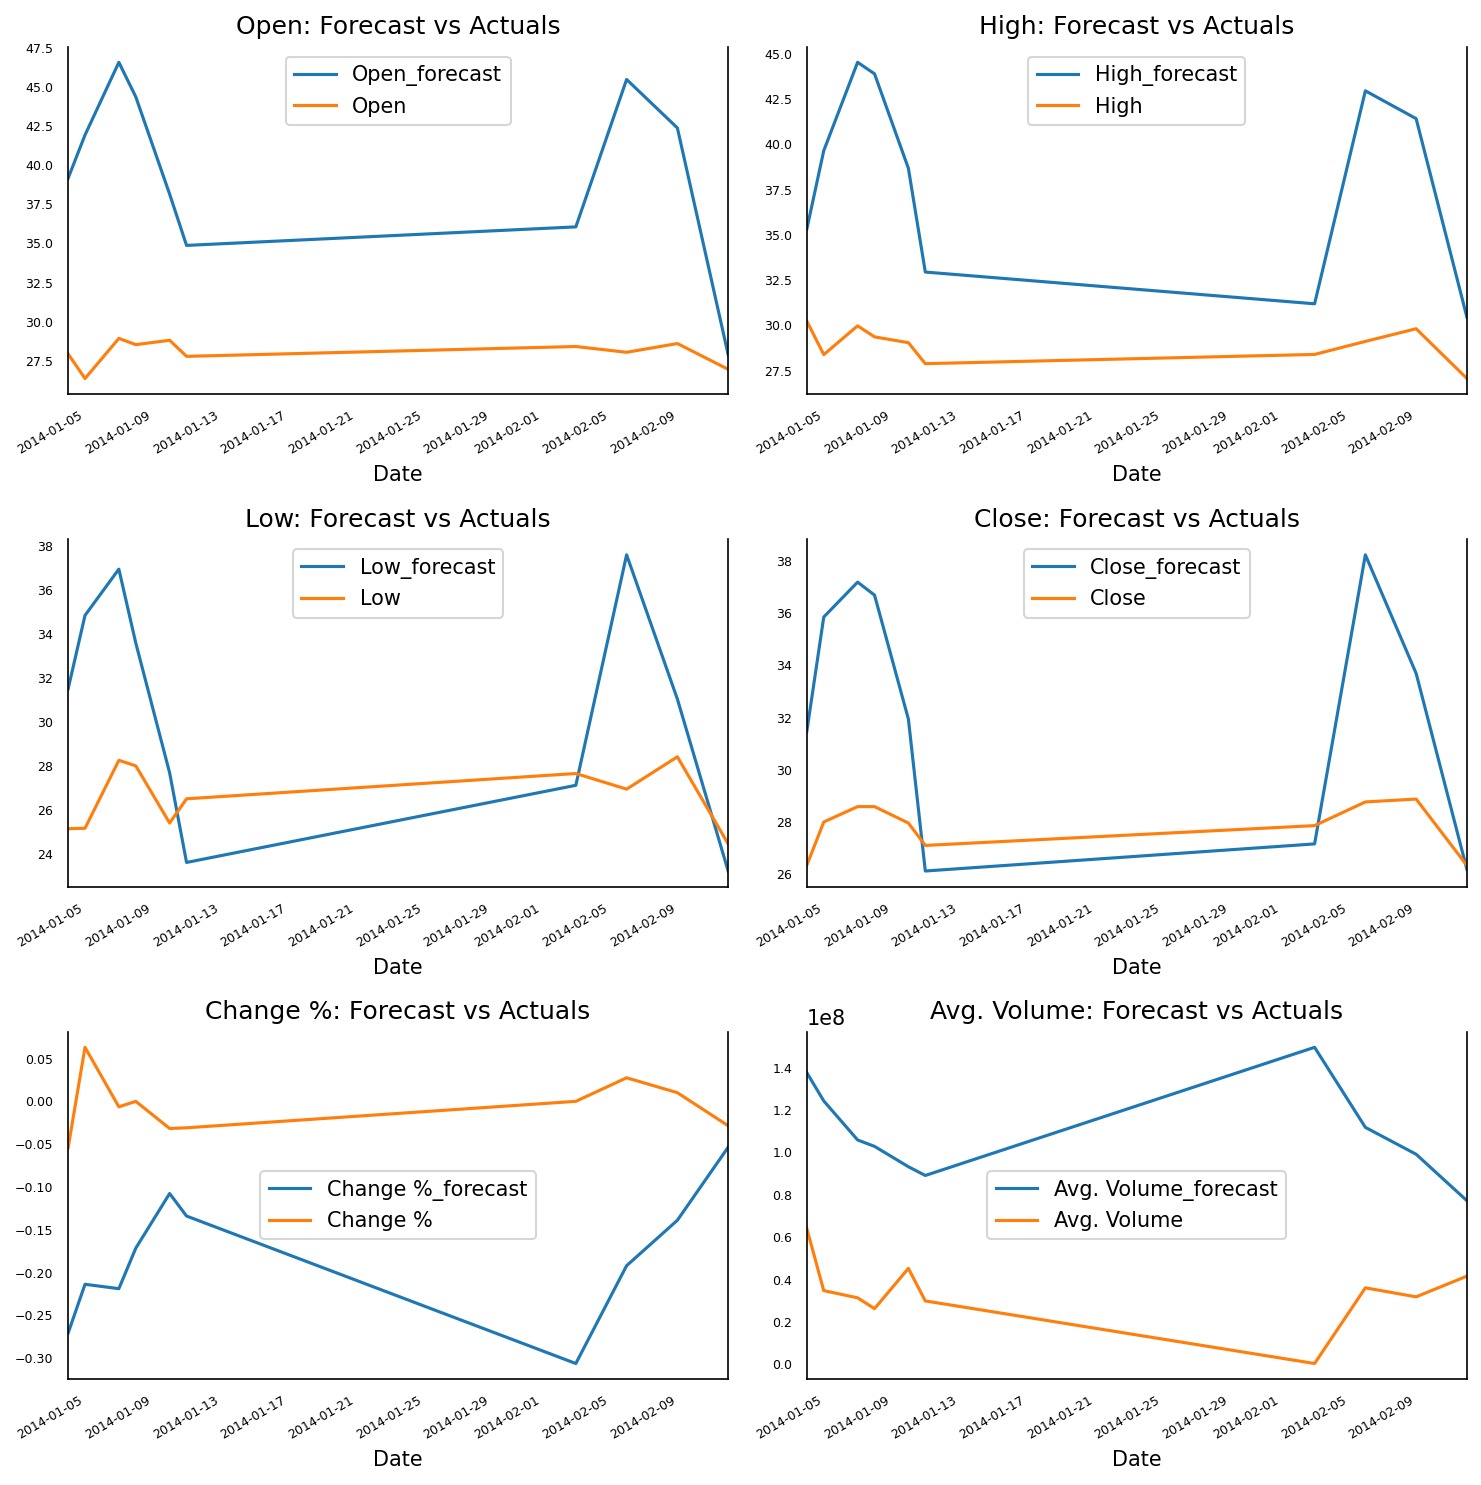

In [162]:
fig, axes = plt.subplots(nrows=int(len(stock_data1.columns)/2), ncols=2, dpi=150, figsize=(10,10))
for i, (col,ax) in enumerate(zip(stock_data1.columns, axes.flatten())):
    df_results[col+'_forecast'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    stock_data1_test[col][-nobs:].plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

Evaluate the Forecasts
To evaluate the forecasts, let’s compute a comprehensive set of metrics, namely, the MAPE, ME, MAE, MPE, RMSE, corr and minmax.

In [163]:
from statsmodels.tsa.stattools import acf
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'corr':corr, 'minmax':minmax})

print('Forecast Accuracy of: Open')
accuracy_prod = forecast_accuracy(df_results['Open_forecast'].values, stock_data1_test['Open'])
for k, v in accuracy_prod.items():
    print((k), ': ', round(v,4))

print('\nForecast Accuracy of: High')
accuracy_prod = forecast_accuracy(df_results['High_forecast'].values, stock_data1_test['High'])
for k, v in accuracy_prod.items():
    print((k), ': ', round(v,4))

print('\nForecast Accuracy of: Low')
accuracy_prod = forecast_accuracy(df_results['Low_forecast'].values, stock_data1_test['Low'])
for k, v in accuracy_prod.items():
    print((k), ': ', round(v,4))

print('\nForecast Accuracy of: Close')
accuracy_prod = forecast_accuracy(df_results['Close_forecast'].values, stock_data1_test['Close'])
for k, v in accuracy_prod.items():
    print((k), ': ', round(v,4))

print('\nForecast Accuracy of: Change %')
accuracy_prod = forecast_accuracy(df_results['Change %_forecast'].values, stock_data1_test['Change %'])
for k, v in accuracy_prod.items():
    print((k), ': ', round(v,4))

print('\nForecast Accuracy of: Avg. Column')
accuracy_prod = forecast_accuracy(df_results['Avg. Volume_forecast'].values, stock_data1_test['Avg. Volume'])
for k, v in accuracy_prod.items():
    print((k), ': ', round(v,4))

Forecast Accuracy of: Open
mape :  0.4155
me :  11.6759
mae :  11.6759
mpe :  0.4155
rmse :  12.7608
corr :  0.4186
minmax :  0.2801

Forecast Accuracy of: High
mape :  0.3147
me :  9.1768
mae :  9.1768
mpe :  0.3147
rmse :  10.1972
corr :  0.6726
minmax :  0.2292

Forecast Accuracy of: Low
mape :  0.1902
me :  4.1211
mae :  5.0539
mpe :  0.1543
rmse :  6.1376
corr :  0.3918
minmax :  0.1511

Forecast Accuracy of: Close
mape :  0.1769
me :  4.6221
mae :  4.9889
mpe :  0.1635
rmse :  5.994
corr :  0.7344
minmax :  0.1419

Forecast Accuracy of: Change %
mape :  inf
me :  -0.1756
mae :  0.1756
mpe :  -inf
rmse :  0.1947
corr :  -0.1812
minmax :  inf

Forecast Accuracy of: Avg. Column
mape :  36.2134
me :  74872874.8591
mae :  74872874.8591
mpe :  36.2134
rmse :  80227231.9326
corr :  -0.2321
minmax :  0.6693


C:\Users\ARKYA BANERJEE\AppData\Local\Temp\ipykernel_13536\783887558.py:10: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.

C:\Users\ARKYA BANERJEE\AppData\Local\Temp\ipykernel_13536\783887558.py:12: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.

C:\Users\ARKYA BANERJEE\AppData\Local\Temp\ipykernel_13536\783887558.py:13: RuntimeWarning:

divide by zero encountered in divide

